# Cyclist - Density Based Clustering (DBSCAN)

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.cluster.hierarchy import fcluster

from scipy.spatial.distance import pdist, squareform
from kneed import KneeLocator

In [3]:
dataset = pd.read_csv('../../data/complete_dataset_fe.csv', dtype={'cyclist_team': str})
dataset['date'] = pd.to_datetime(dataset['date'], format='%Y-%m-%d')

In [4]:
'''
Clustering Features Cyclists:
- cyclist_bmi (ignore: weight)
- height
- mean_delta
- cyclist_climb_power
'''

'\nClustering Features Cyclists:\n- cyclist_bmi (ignore: weight)\n- height\n- mean_delta\n- cyclist_climb_power\n'

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589739 entries, 0 to 589738
Data columns (total 31 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   cyclist_url                   589739 non-null  object        
 1   cyclist_name                  589739 non-null  object        
 2   birth_year                    589739 non-null  int64         
 3   weight                        480007 non-null  float64       
 4   height                        480007 non-null  float64       
 5   nationality                   589739 non-null  object        
 6   race_url                      589739 non-null  object        
 7   race_name                     589739 non-null  object        
 8   points                        589739 non-null  float64       
 9   uci_points                    422184 non-null  float64       
 10  length                        589739 non-null  float64       
 11  climb_total  

In [6]:
# Step 1: Calculate the mean delta for each cyclist
mean_delta = dataset.groupby('cyclist_url')['delta'].mean()
mean_bmi = dataset.groupby('cyclist_url')['cyclist_bmi'].mean()
mean_height = dataset.groupby('cyclist_url')['height'].mean()
mean_cp = dataset.groupby('cyclist_url')['cyclist_climb_power'].mean()

# Step 2: Map the mean delta back to each row
dataset['mean_delta'] = dataset['cyclist_url'].map(mean_delta)
dataset['mean_bmi'] = dataset['cyclist_url'].map(mean_bmi)
dataset['mean_height'] = dataset['cyclist_url'].map(mean_height)
dataset['mean_cp'] = dataset['cyclist_url'].map(mean_cp)


dataset = dataset[['mean_bmi','mean_height', 'mean_delta', 'mean_cp']].drop_duplicates()

In [7]:
# Select relevant columns for clustering
columns_to_use = ['mean_bmi','mean_height', 'mean_delta', 'mean_cp']

data_for_clustering = dataset.dropna() #TODO: remove when we have imputed the missing values

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

#### Model Selection

In [8]:
dist = squareform(pdist(data_scaled, 'euclidean'))
min_points = range(2, 20)
optimal_eps = []
optimal_index = []
cluster_count = []
silhouette_scores = []



for i, value in enumerate(min_points):
    k = value - 1 #standard value?
    
    #print("k = ", k)
    
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])

    sorted_distances = sorted(kth_distances)
    indices = range(0, len(kth_distances))
    
    #print("sorted_distances = ", sorted_distances)
    #print("indices = ", indices)

    # Use the KneeLocator to find the knee point
    kneedle = KneeLocator(indices, sorted_distances, curve="convex", direction="increasing")

    #print("kneedle.knee = ", kneedle.knee)
    
    if(kneedle.knee is None):
        optimal_eps.append(None)  # The y-value at the knee
        optimal_index.append(None)  # The x-value (index)
        silhouette_scores.append(None)
        continue
    
    # Get the knee (optimal epsilon)
    optimal_eps.append(sorted_distances[kneedle.knee])  # The y-value at the knee
    optimal_index.append(kneedle.knee)  # The x-value (index)
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=optimal_eps[i], min_samples=value)
    clusters = dbscan.fit_predict(data_scaled)

    # Add cluster labels to the data
    data_for_clustering['cluster'] = clusters
    number_of_clusters = data_for_clustering['cluster'].nunique()
    cluster_count.append(number_of_clusters)
    
    if(number_of_clusters < 3): # Considering that a cluster is that of outliers, to compite silhouette we need at least 3 clusters here
        silhouette_scores.append(None)
        continue
    
    # Removing outliers so to not include them in silhouette calculation
    no_out_data_scaled = scaler.fit_transform(data_for_clustering[data_for_clustering['cluster'] != -1])
    no_out_labels = dbscan.labels_[dbscan.labels_ != -1]

    # Calculate Silhouette
    silhouette_scores.append(silhouette_score(no_out_data_scaled, no_out_labels))
    

# Creating the DataFrame
model_selection_data = {"min_points": min_points, "optimal_eps": optimal_eps, "optimal_index": optimal_index, "cluster_count": cluster_count, "silhouette_score": silhouette_scores}
model_selection_df = pd.DataFrame(model_selection_data)

model_selection_df

/tmp/ipykernel_7496/2745289044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_clustering['cluster'] = clusters
/tmp/ipykernel_7496/2745289044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_clustering['cluster'] = clusters
/tmp/ipykernel_7496/2745289044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

,min_points,optimal_eps,optimal_index,cluster_count,silhouette_score
0,2,1.162431,3037,7,0.61758
1,3,1.175193,3024,2,NaN
2,4,1.237387,3020,2,NaN
3,5,1.223608,3006,2,NaN
4,6,1.607873,3033,2,NaN
5,7,1.572402,3027,2,NaN
6,8,1.515913,3016,2,NaN
7,9,1.489817,3011,2,NaN
8,10,1.752307,3029,2,NaN
9,11,1.693896,3021,2,NaN


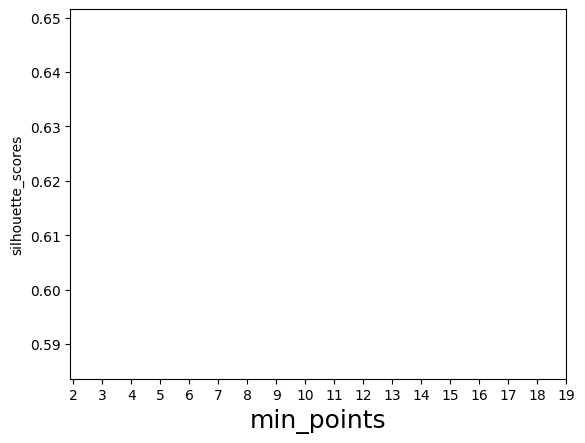

In [9]:
x = model_selection_df[model_selection_df['cluster_count'] > 2]['min_points']
y = model_selection_df[model_selection_df['cluster_count'] > 2]['silhouette_score']

plt.plot(x, y)
plt.ylabel('silhouette_scores')
plt.xlabel('min_points', fontsize=18)
plt.xticks(min_points)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

#### Chosen Parameter Clustering

(4680270,)
(3060, 3060)
Optimal epsilon (eps): 1.162430594047495
Knee point index: 3037


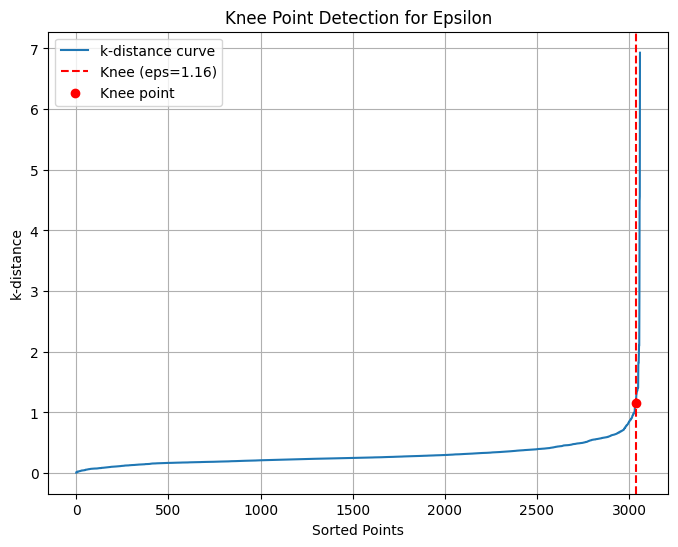

In [10]:
min_points = 2

dist = pdist(data_scaled, 'euclidean') #pair wise distance
print (dist.shape)
dist = squareform(dist) #distance matrix given the vector dist
print(dist.shape)

k = min_points - 1 #standard value?
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

sorted_distances = sorted(kth_distances)
indices = range(0, len(kth_distances))

# Use the KneeLocator to find the knee point
kneedle = KneeLocator(indices, sorted_distances, curve="convex", direction="increasing")

# Get the knee (optimal epsilon)
optimal_eps = sorted_distances[kneedle.knee]  # The y-value at the knee
optimal_index = kneedle.knee  # The x-value (index)

print(f"Optimal epsilon (eps): {optimal_eps}")
print(f"Knee point index: {optimal_index}")

# Plot the k-distance graph with the knee point marked
plt.figure(figsize=(8, 6))
plt.plot(indices, sorted_distances, label="k-distance curve")
plt.axvline(optimal_index, linestyle="--", color="r", label=f"Knee (eps={optimal_eps:.2f})")
plt.scatter(optimal_index, optimal_eps, color="red", label="Knee point", zorder=5)
plt.xlabel("Sorted Points")
plt.ylabel("k-distance")
plt.title("Knee Point Detection for Epsilon")
plt.legend()
plt.grid()
plt.show()

#### Selection of best eps

In [11]:
# Apply DBSCAN
dbscan = DBSCAN(eps=optimal_eps, min_samples=min_points)
clusters = dbscan.fit_predict(data_scaled)

# Add cluster labels to the data
data_for_clustering['cluster'] = clusters

# Display cluster distribution
print(data_for_clustering['cluster'].value_counts())
print(data_for_clustering.head())

cluster
 0    3026
-1      22
 3       4
 1       2
 2       2
 4       2
 5       2
Name: count, dtype: int64
      mean_bmi  mean_height  mean_delta   mean_cp  cluster
0    22.256908        186.0  398.568966  0.001487        0
58   21.672110        181.0  847.935484  0.002883        0
89   22.282592        181.0  404.819672  0.003047        0
196  21.705129        177.0  458.285714  0.000045        0
203  20.756387        181.0  559.000000  0.000031        0


/tmp/ipykernel_7496/4157897731.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_clustering['cluster'] = clusters


In [12]:
np.unique(dbscan.labels_, return_counts=True)


(array([-1,  0,  1,  2,  3,  4,  5]),
 array([  22, 3026,    2,    2,    4,    2,    2]))

In [13]:
# Identify outliers (cluster label -1)
outliers = data_for_clustering[data_for_clustering['cluster'] == -1]
print("\nNumber of outliers:", len(outliers))


Number of outliers: 22


In [14]:
# Analyze the mean and standard deviation of numerical features for each cluster
cluster_stats = data_for_clustering.groupby('cluster').agg(['mean', 'std'])
print("Cluster Statistics:\n", cluster_stats)

Cluster Statistics:
           mean_bmi           mean_height              mean_delta               \
              mean       std        mean        std         mean          std   
cluster                                                                         
-1       22.214831  2.680979  178.954545  11.565455  1857.795781  1830.692949   
 0       21.183568  1.332624  179.868143   6.379264   513.346778   222.799580   
 1       20.299215  0.283952  198.500000   2.121320   250.418768   215.283314   
 2       21.009654  0.374179  187.500000   3.535534   376.971429    18.425182   
 3       20.368094  0.795661  185.000000   1.632993   105.777109    84.204556   
 4       23.248561  0.198168  171.000000   2.828427  1536.872078   148.452936   
 5       22.727642  0.183142  175.500000   0.707107  2711.850649   207.292485   

          mean_cp            
             mean       std  
cluster                      
-1       0.003077  0.005935  
 0       0.001993  0.001526  
 1       0.006262 

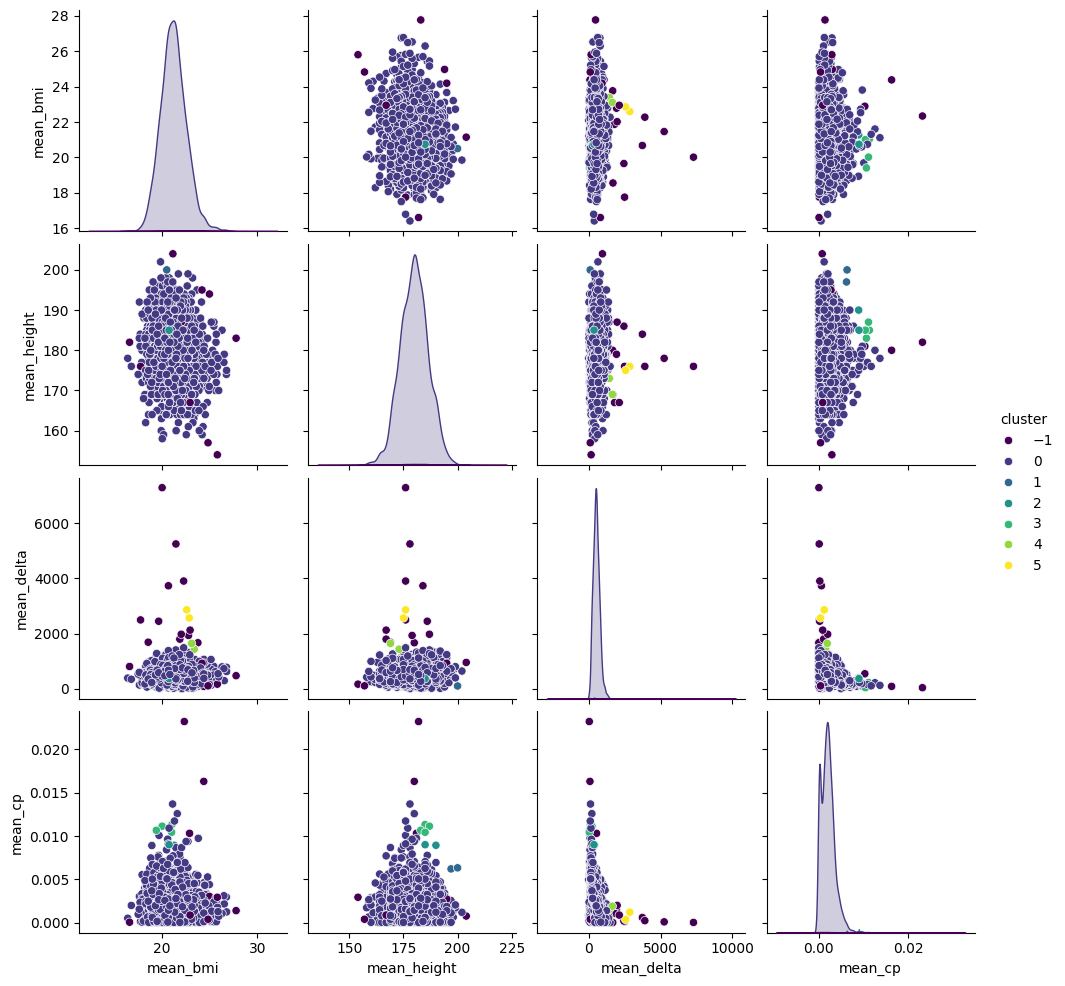

In [15]:

# Pair plot for a subset of columns
data_subset = data_for_clustering[['mean_bmi','mean_height', 'cluster', 'mean_delta', 'mean_cp']]
sns.pairplot(data_subset, hue='cluster', palette='viridis')
plt.show()

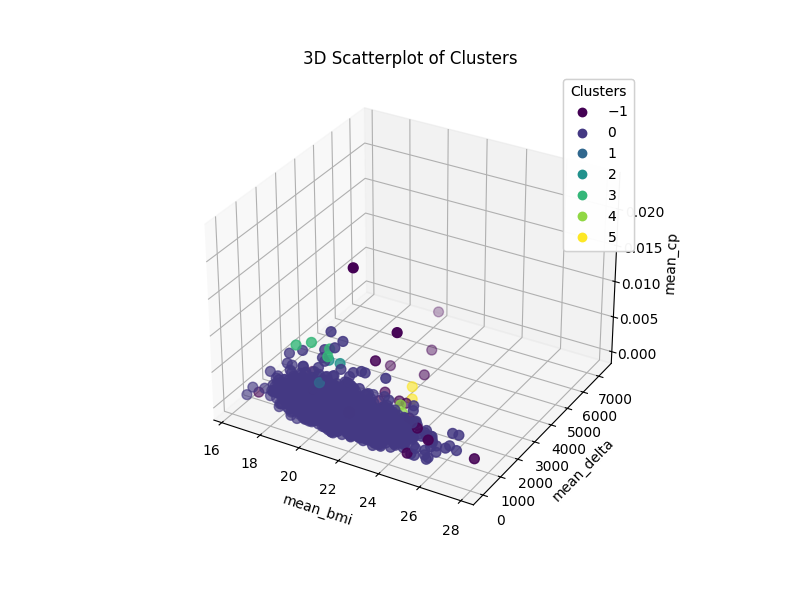

In [16]:
%matplotlib widget

x = data_for_clustering['mean_bmi']  # Prima feature
y = data_for_clustering['mean_delta']  # Seconda feature
z = data_for_clustering['mean_cp']  # Terza feature

# Crea il grafico 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatterplot
scatter = ax.scatter(x, y, z, c=data_for_clustering['cluster'], cmap='viridis', s=50)
ax.set_xlabel('mean_bmi')
ax.set_ylabel('mean_delta')
ax.set_zlabel('mean_cp')

# Aggiungi una legenda (opzionale)
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.title('3D Scatterplot of Clusters')

# Abilita la modalità interattiva
plt.ion()
plt.show()

In [17]:
data_scaled = scaler.fit_transform(data_for_clustering[data_for_clustering['cluster'] != -1])
no_out_labels = dbscan.labels_[dbscan.labels_ != -1]

print('Silhouette %s' % silhouette_score(data_scaled, no_out_labels))

Silhouette 0.6175802192855591
